In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/global/homes/a/abayer/source/pymc3')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as T

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

Running on PyMC3 v3.11.0


# LOAD GMMN10 STUFF

In [2]:
hdim = 10
Xdim = 28
model_type = 'gmmn10'
aux=''
sigma = 0.025
num_test = num_simulated_samples = 100

batches = [4,5]   # consider images 4 and 5

In [3]:
def load_model(model_type,aux):
    # load_model returns a generator, which is a python function that 
    # takes a latent variable as input and returns a sample.

    if model_type == 'gmmn10':
        params = np.load(model_type+'.npy', allow_pickle=True, encoding='bytes')
        def generator(x):
            y = x
            for k in range(5):
                y = T.dot(y,params[k][0].astype('float32')) + params[k][1].astype('float32')
                if k==4:
                    y = T.nnet.sigmoid(y)
                else:
                    y = T.nnet.relu(y)
            return y
        
        return None,generator

In [4]:
model, generator = load_model(model_type,aux)

In [12]:
def likelihood(obs, generated):
    k = Xdim*Xdim
    llk = -T.sum(T.square(generated-obs)) / (2*sigma) - k/2.*np.log(2 * np.pi)-k/2.*np.log(sigma)
    return llk

def generate(state):
    n_sam = 1
    generated = generator(state)
    generated = T.reshape(generated,[n_sam,28,28])
    return generated

In [13]:
def gmmn10_llk(X, h):    # takes only 1 28*28 pixel image at a time
    generated = generate(h)
    return likelihood(X, generated)

In [14]:
# LOAD EXAMPLE IMAGE DATA (BDMC DATA)

exact_h = np.random.RandomState(seed=2039).normal(0,1,size=[num_simulated_samples,hdim]).astype(np.float32)

permutation = np.random.RandomState(seed=2919).permutation(exact_h.shape[0])
exact_h = exact_h[permutation][:num_test]

X0 = (generator(exact_h)).eval()
X = X0 + np.random.RandomState(seed=1429).normal(0,np.sqrt(sigma),size=X0.shape).astype(np.float32)

X0 = X0.reshape(num_simulated_samples, Xdim, Xdim)   # make 28*28
X = X.reshape(num_simulated_samples, Xdim, Xdim)   # make 28*28

In [47]:
# SA and SMC (aka ESA) samples
info_SA  = np.load("ais_finalstate_samples_gmmn10_BDMC_nte100_nst5000_nsa1000_seed0_Ntrain1000_Niter10_fast12.npz")
info_SMC = np.load("ais_finalstate_samples_gmmn10_BDMC_nte100_nst10_nsa1000_seed0_tar65_L50_eps1.00e-02_smcthresh7.00e-01_smcresam1_forcerej_mommagresample_warmup0down100_Ntrain1000_Niter10_fast12.npz")

xp_SA  = info_SA['xp']
xp_SMC = info_SMC['xp']

## A reminder of what the samples look like using SA and SMC+HMC (aka ESA)

### BATCH 4
<img src="triSA_b4.png">

### BATCH 5
<img src="triSA_b5.png">

# NUTS

In [17]:
nuts_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        
        nuts_trace = pm.sample(1000)
        nuts_az_trace = az.from_pymc3(nuts_trace)
        nuts_az_traces.append(nuts_az_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14661 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/global/homes/a/abayer/source/pymc3/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3453 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


BATCH 4


<Figure size 720x480 with 0 Axes>

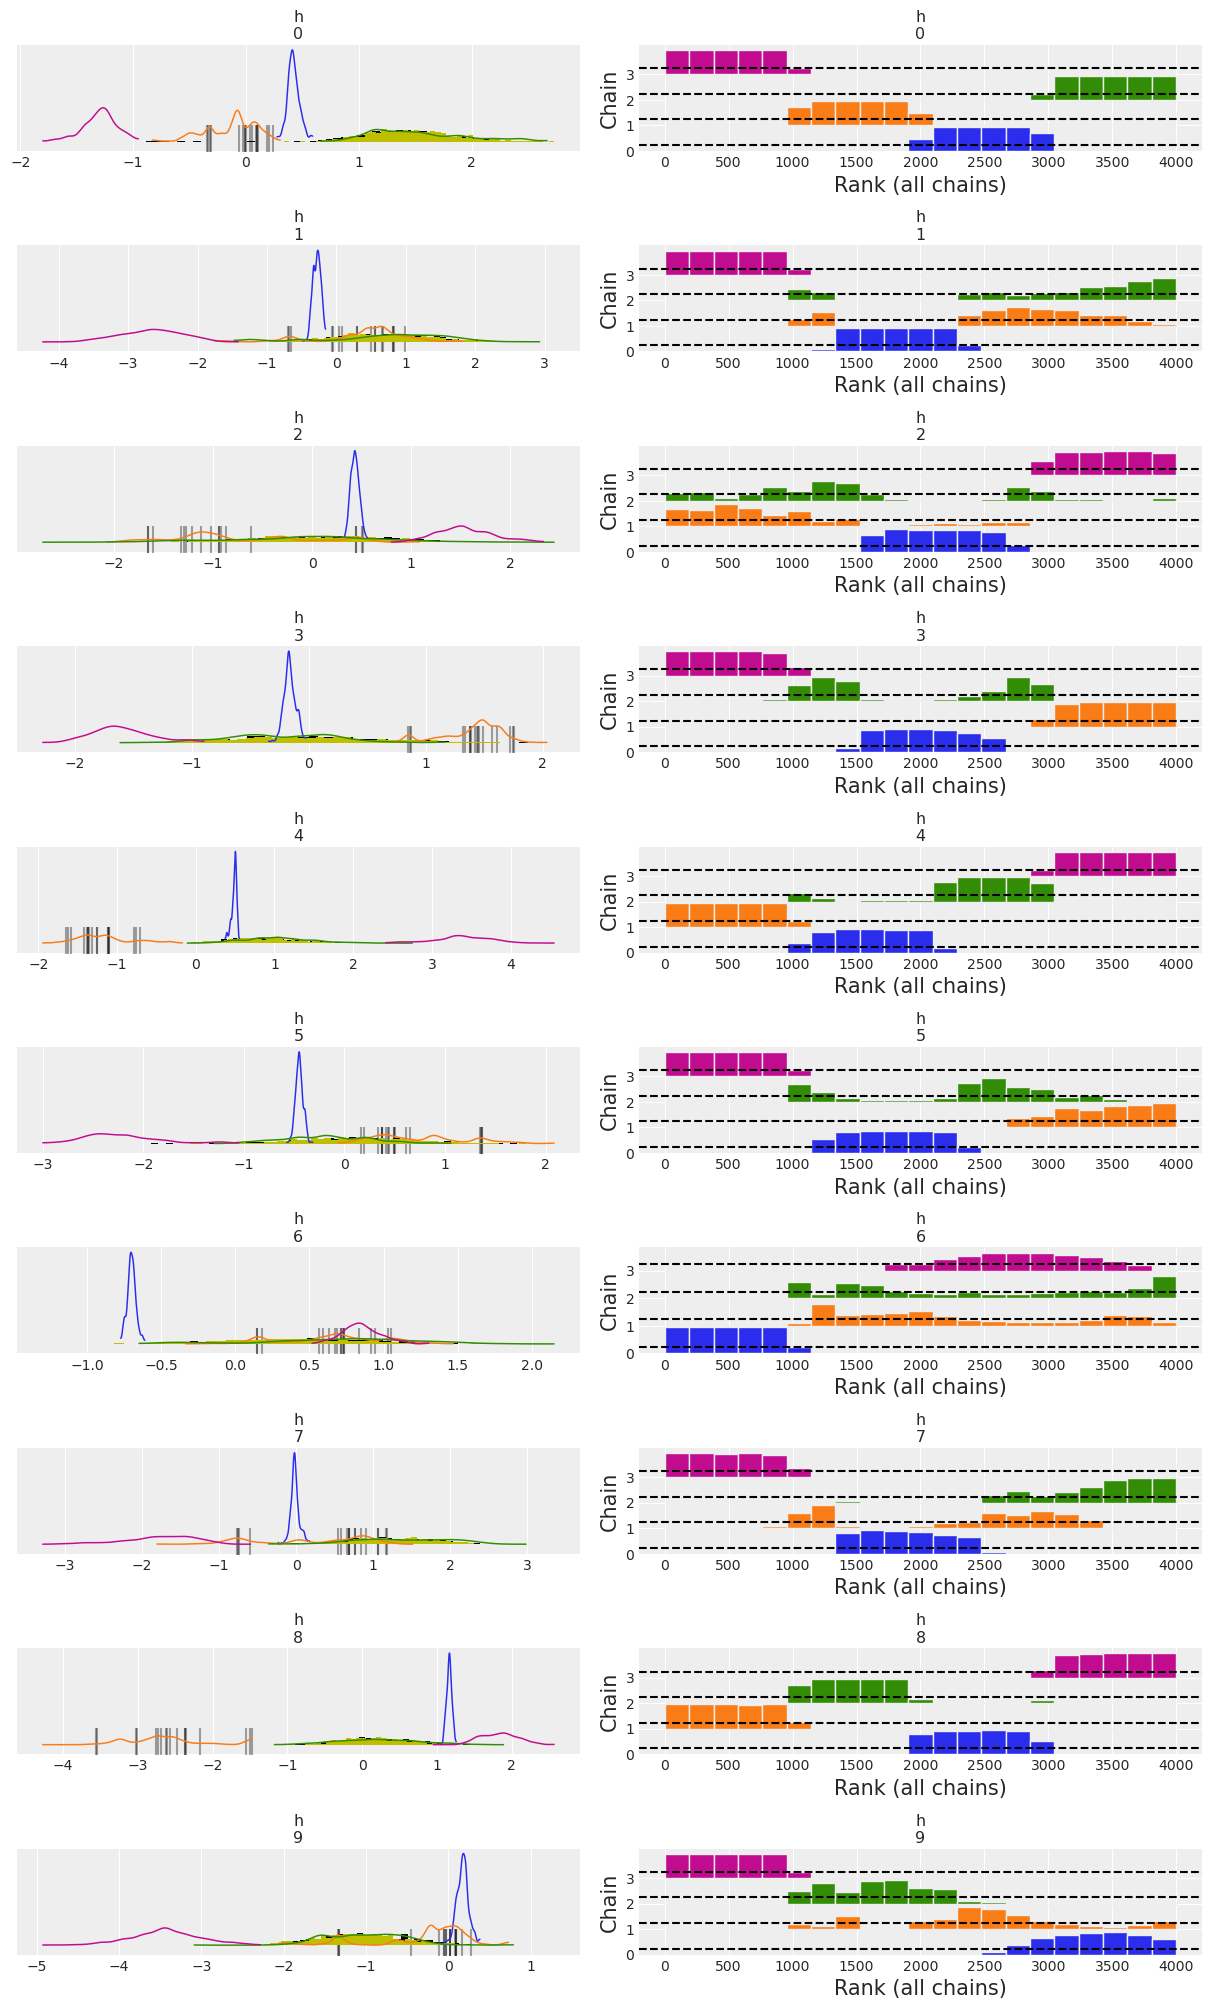

BATCH 5


<Figure size 720x480 with 0 Axes>

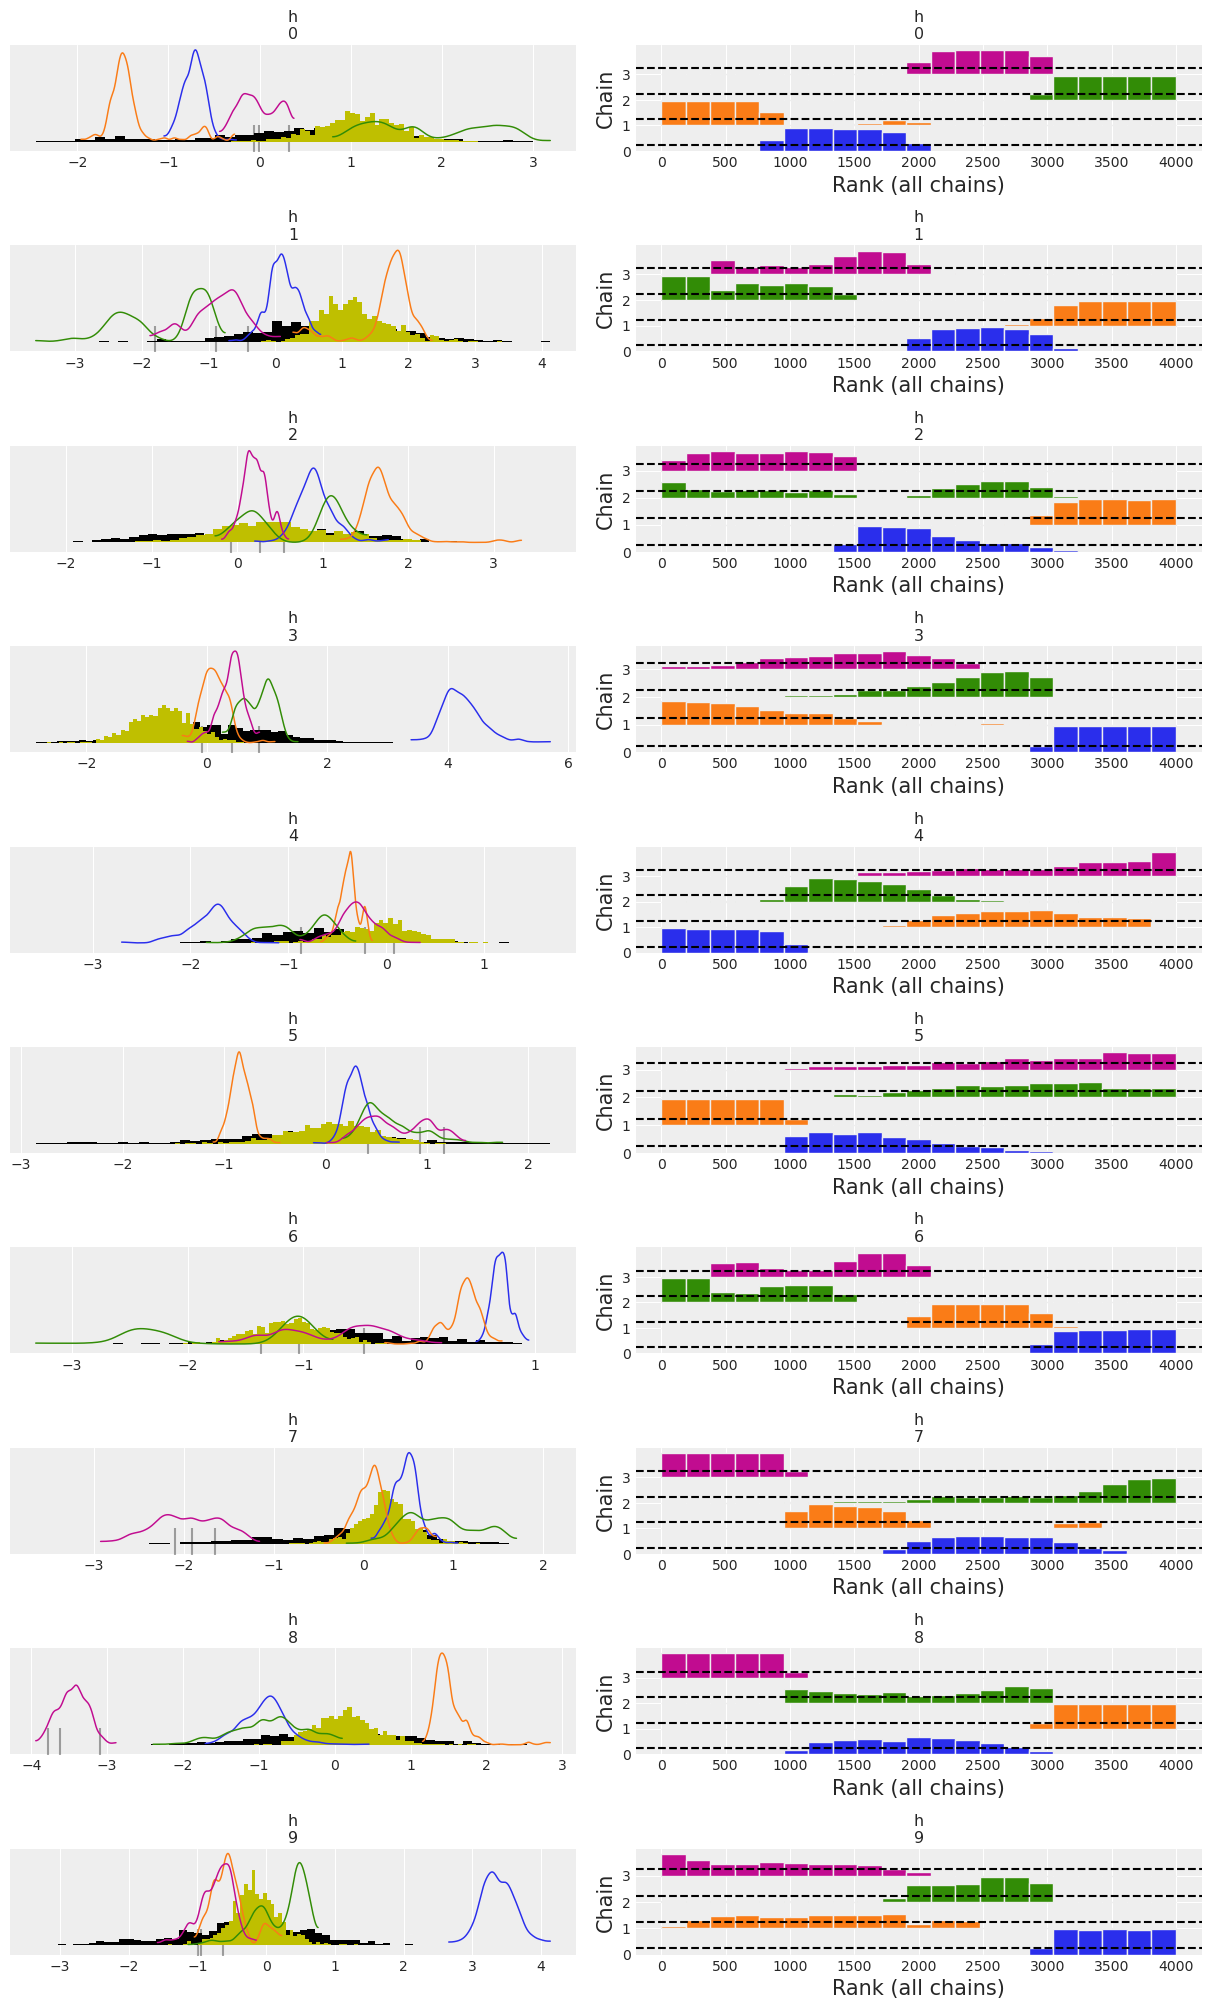

In [39]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(nuts_az_traces[ib], compact=False, kind="rank_bars")
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()

# SMC (pymc3)

In [34]:
smc_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        
        smc_trace = pm.sample_smc(1000, chains=2, cores=0)
        init_samples = smc_trace.get_values('h')
        print(np.shape(init_samples))

        smc_az_traces.append(az.from_pymc3(smc_trace))

Initializing SMC sampler...
Sampling 2 chains in 0 job
/global/homes/a/abayer/source/pymc3/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.006
Stage:   4 Beta: 0.011
Stage:   5 Beta: 0.022
Stage:   6 Beta: 0.038
Stage:   7 Beta: 0.062
Stage:   8 Beta: 0.102
Stage:   9 Beta: 0.171
Stage:  10 Beta: 0.286
Stage:  11 Beta: 0.480
Stage:  12 Beta: 0.874
Stage:  13 Beta: 1.000
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.006
Stage:   4 Beta: 0.010
Stage:   5 Beta: 0.020
Stage:   6 Beta: 0.035
Stage:   7 Beta: 0.057
Stage:   8 Beta: 0.091
Stage:   9 Beta: 0.154
Stage:  10 Beta: 0.267
Stage:  11 Beta: 0.456
Stage:  12 Beta: 0.765
Stage:  13 Beta: 1.000


(2000, 10)


Initializing SMC sampler...
Sampling 2 chains in 0 job
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.007
Stage:   3 Beta: 0.010
Stage:   4 Beta: 0.014
Stage:   5 Beta: 0.020
Stage:   6 Beta: 0.032
Stage:   7 Beta: 0.047
Stage:   8 Beta: 0.066
Stage:   9 Beta: 0.096
Stage:  10 Beta: 0.154
Stage:  11 Beta: 0.329
Stage:  12 Beta: 0.655
Stage:  13 Beta: 1.000
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.007
Stage:   3 Beta: 0.010
Stage:   4 Beta: 0.015
Stage:   5 Beta: 0.023
Stage:   6 Beta: 0.036
Stage:   7 Beta: 0.052
Stage:   8 Beta: 0.074
Stage:   9 Beta: 0.111
Stage:  10 Beta: 0.186
Stage:  11 Beta: 0.339
Stage:  12 Beta: 0.735
Stage:  13 Beta: 1.000


(2000, 10)


BATCH 4


<Figure size 720x480 with 0 Axes>

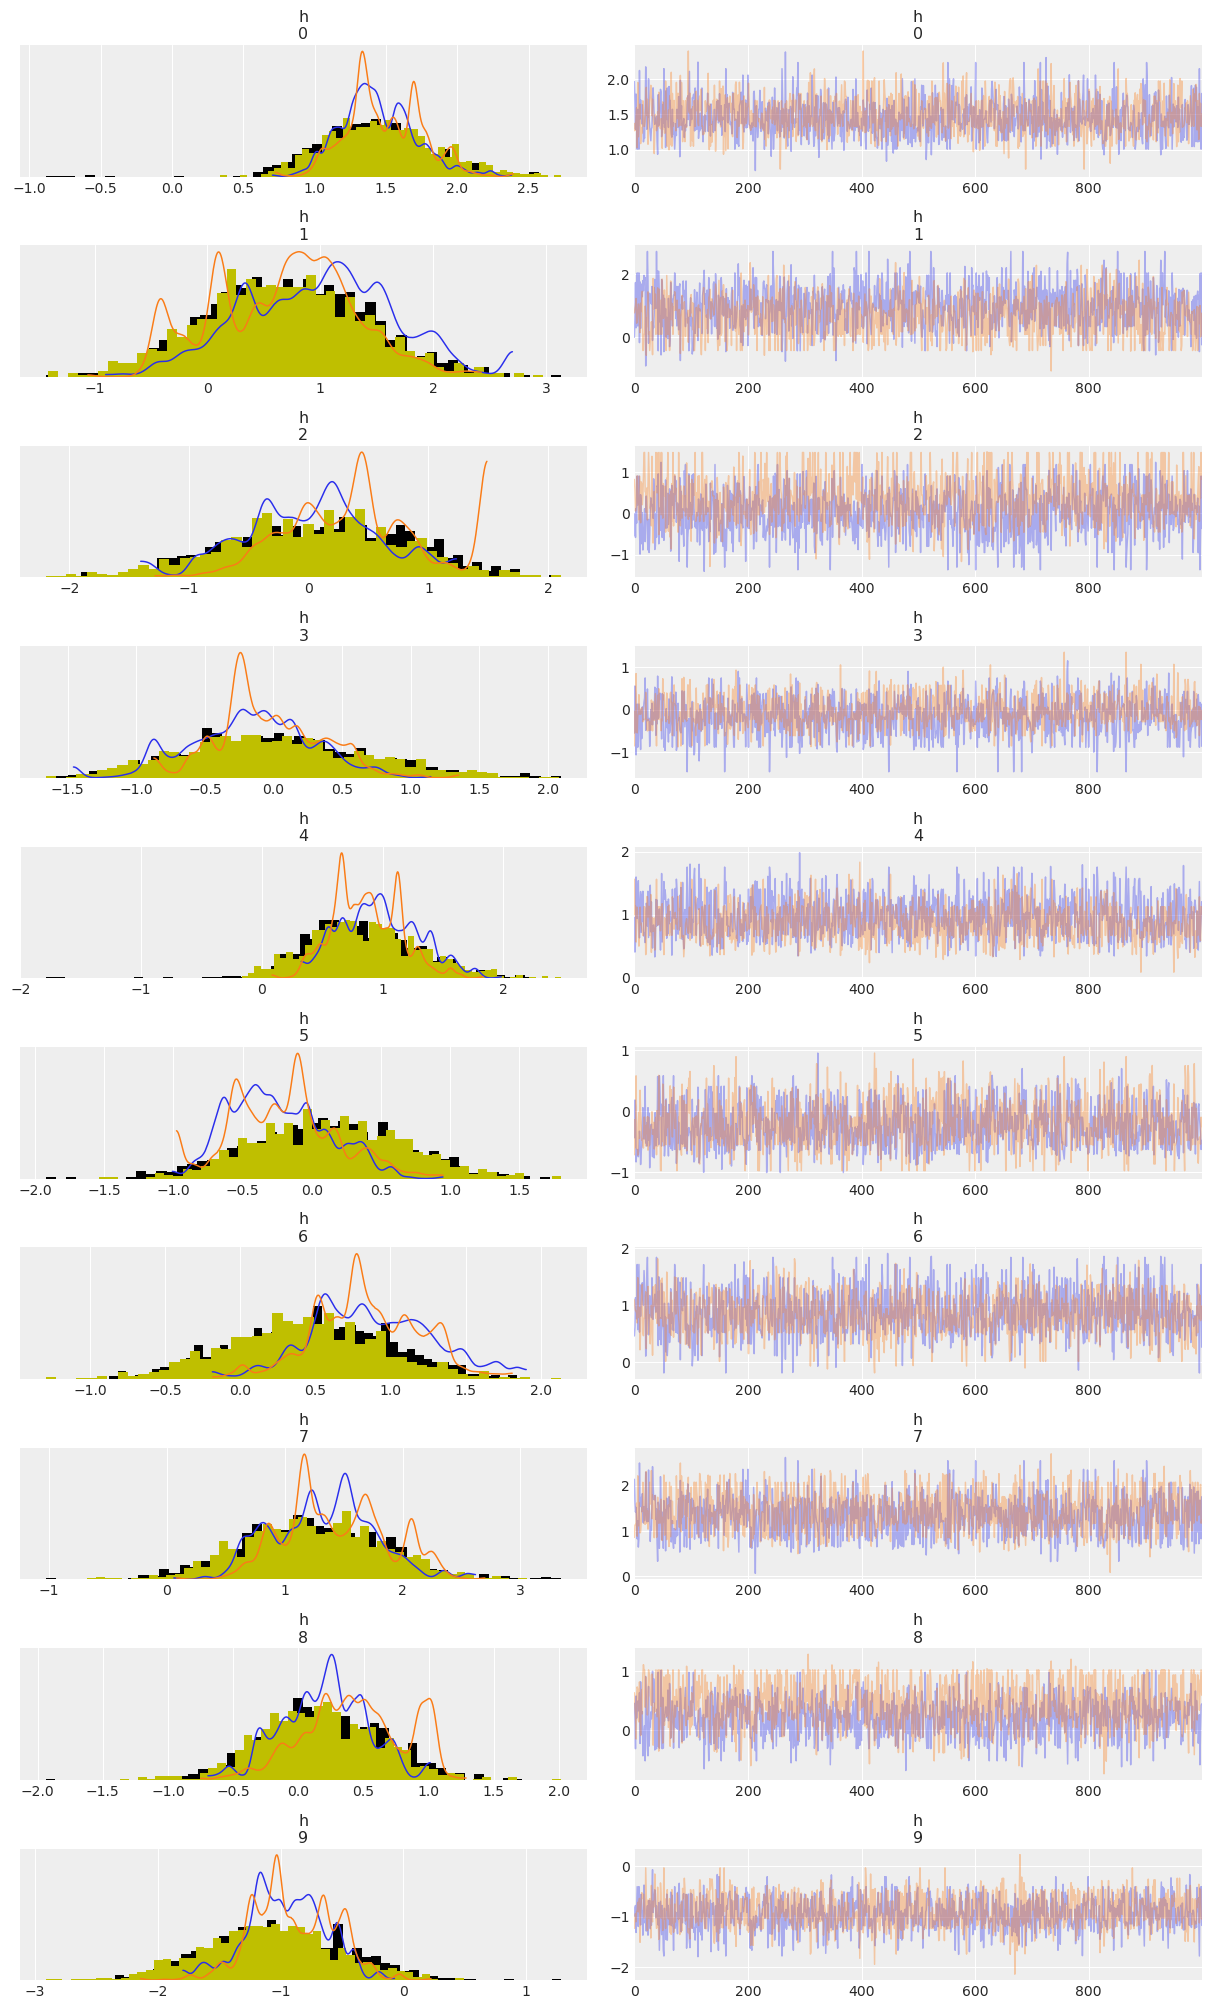

BATCH 5


<Figure size 720x480 with 0 Axes>

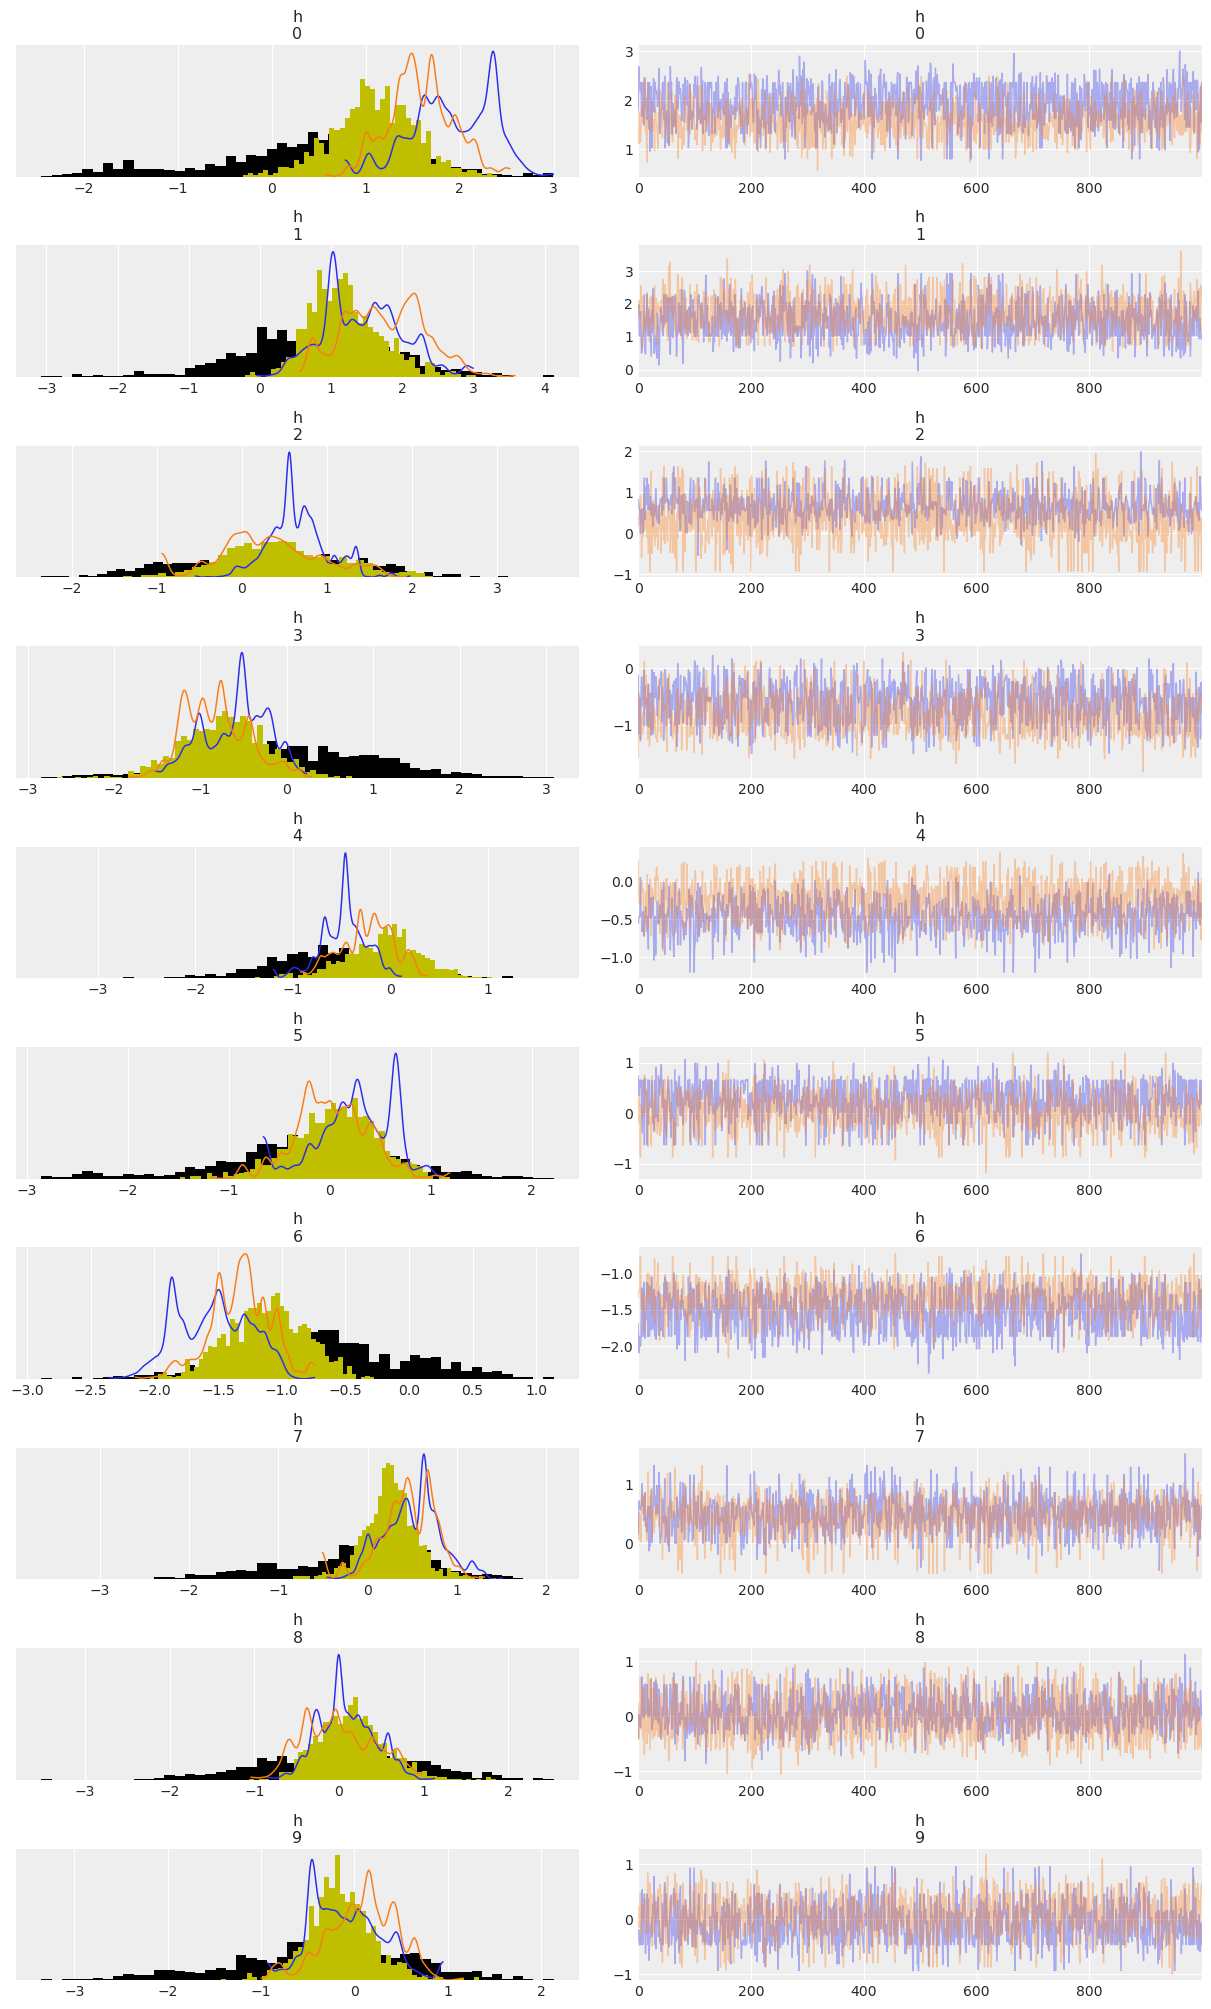

In [35]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(smc_az_traces[ib], compact=False)
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()

# NFMC (performs pymc3-SMC and then runs SINF from there)

In [28]:
nfmc_az_traces = []
smc_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        
        smc_trace = pm.sample_smc(1000, chains=2, cores=0)
        init_samples = smc_trace.get_values('h')
        print(np.shape(init_samples))

        nfmc_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                                    frac_validate=0.2, alpha=(0.75,0.75), parallel=False,
                                    ftol=1.0e-12, NBfirstlayer=True, bw_factor=0.5, k_trunc=0.25, pareto=False)
        nfmc_az_trace = az.from_pymc3(nfmc_trace)
        nfmc_az_traces.append(nfmc_az_trace)
        
        smc_az_traces.append(az.from_pymc3(smc_trace))

Initializing SMC sampler...
Sampling 2 chains in 0 job
/global/homes/a/abayer/source/pymc3/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.006
Stage:   4 Beta: 0.010
Stage:   5 Beta: 0.018
Stage:   6 Beta: 0.033
Stage:   7 Beta: 0.053
Stage:   8 Beta: 0.087
Stage:   9 Beta: 0.144
Stage:  10 Beta: 0.237
Stage:  11 Beta: 0.403
Stage:  12 Beta: 0.689
Stage:  13 Beta: 1.000
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.006
Stage:   4 Beta: 0.010
Stage:   5 Beta: 0.019
Stage:   6 Beta: 0.035
Stage:   7 Beta: 0.056
Stage:   8 Beta: 0.086
Stage:   9 Beta: 0.137
Stage:  10 Beta: 0.230
Stage:  11 Beta: 0.399
Stage:  12 Beta: 0.717
Stage:  13 Beta: 1.000
Initializing normalizing flow based sampling...
Sampling 

(2000, 10)
Prior sample check ...
Shape of prior samples = (2000, 10)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 7.421975673086692e+140


[0. 0. 0. ... 0. 0. 0.]


Stage:   2, Normalizing Constant Estimate: 6.227337085126872e+45


[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
 1.75122506e-255 0.00000000e+000]


Stage:   3, Normalizing Constant Estimate: 6.7720808646288705e+87


[0. 0. 0. ... 0. 0. 0.]


RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [10, 1].  Tensor sizes: [10, 3]

In [ ]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(nfmc_az_traces[ib], compact=False)
    ax = az.plot_trace(smc_az_traces[ib], compact=False)
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()

# NS NFMC

In [20]:
ns_nfmc_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        ns_nfmc_trace = pm.sample_ns_nfmc(5000, rho=0.5, chains=2, frac_validate=0.2, alpha=(0,0), cores=2)
        ns_nfmc_az_trace = az.from_pymc3(ns_nfmc_trace)
        ns_nfmc_az_traces.append(ns_nfmc_az_trace)

Initializing normalizing flow based nested sampling...
Sampling 2 chains in 2 jobs
/global/homes/a/abayer/source/pymc3/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: 0.0
Stage:   3; Evidence ratio: 0.0
Stage:   4; Evidence ratio: 0.0
Stage:   5; Evidence ratio: 0.0
Stage:   6; Evidence ratio: 0.0
Stage:   7; Evidence ratio: 0.0
Stage:   8; Evidence ratio: 0.0
Stage:   9; Evidence ratio: 0.0
Stage:  10; Evidence ratio: [0.]
Stage:  11; Evidence ratio: [1.56733876e-88]
Stage:  12; Evidence ratio: [1.50866886e-85]
Stage:  13; Evidence ratio: [4.94979082e-72]
Stage:  14; Evidence ratio: [1.86050906e-40]
Stage:  15; Evidence ratio: [1.1185522e-26]
Stage:  16; Evidence ratio: [3.63772303e-15]
Stage:  17; Evidence ratio: [8.20877829e-10]
Stage:  

First we'll plot up the results using 5000 samples. Note that things look ok, although the height of both peaks seems a bit high.

BATCH 4


<Figure size 720x480 with 0 Axes>

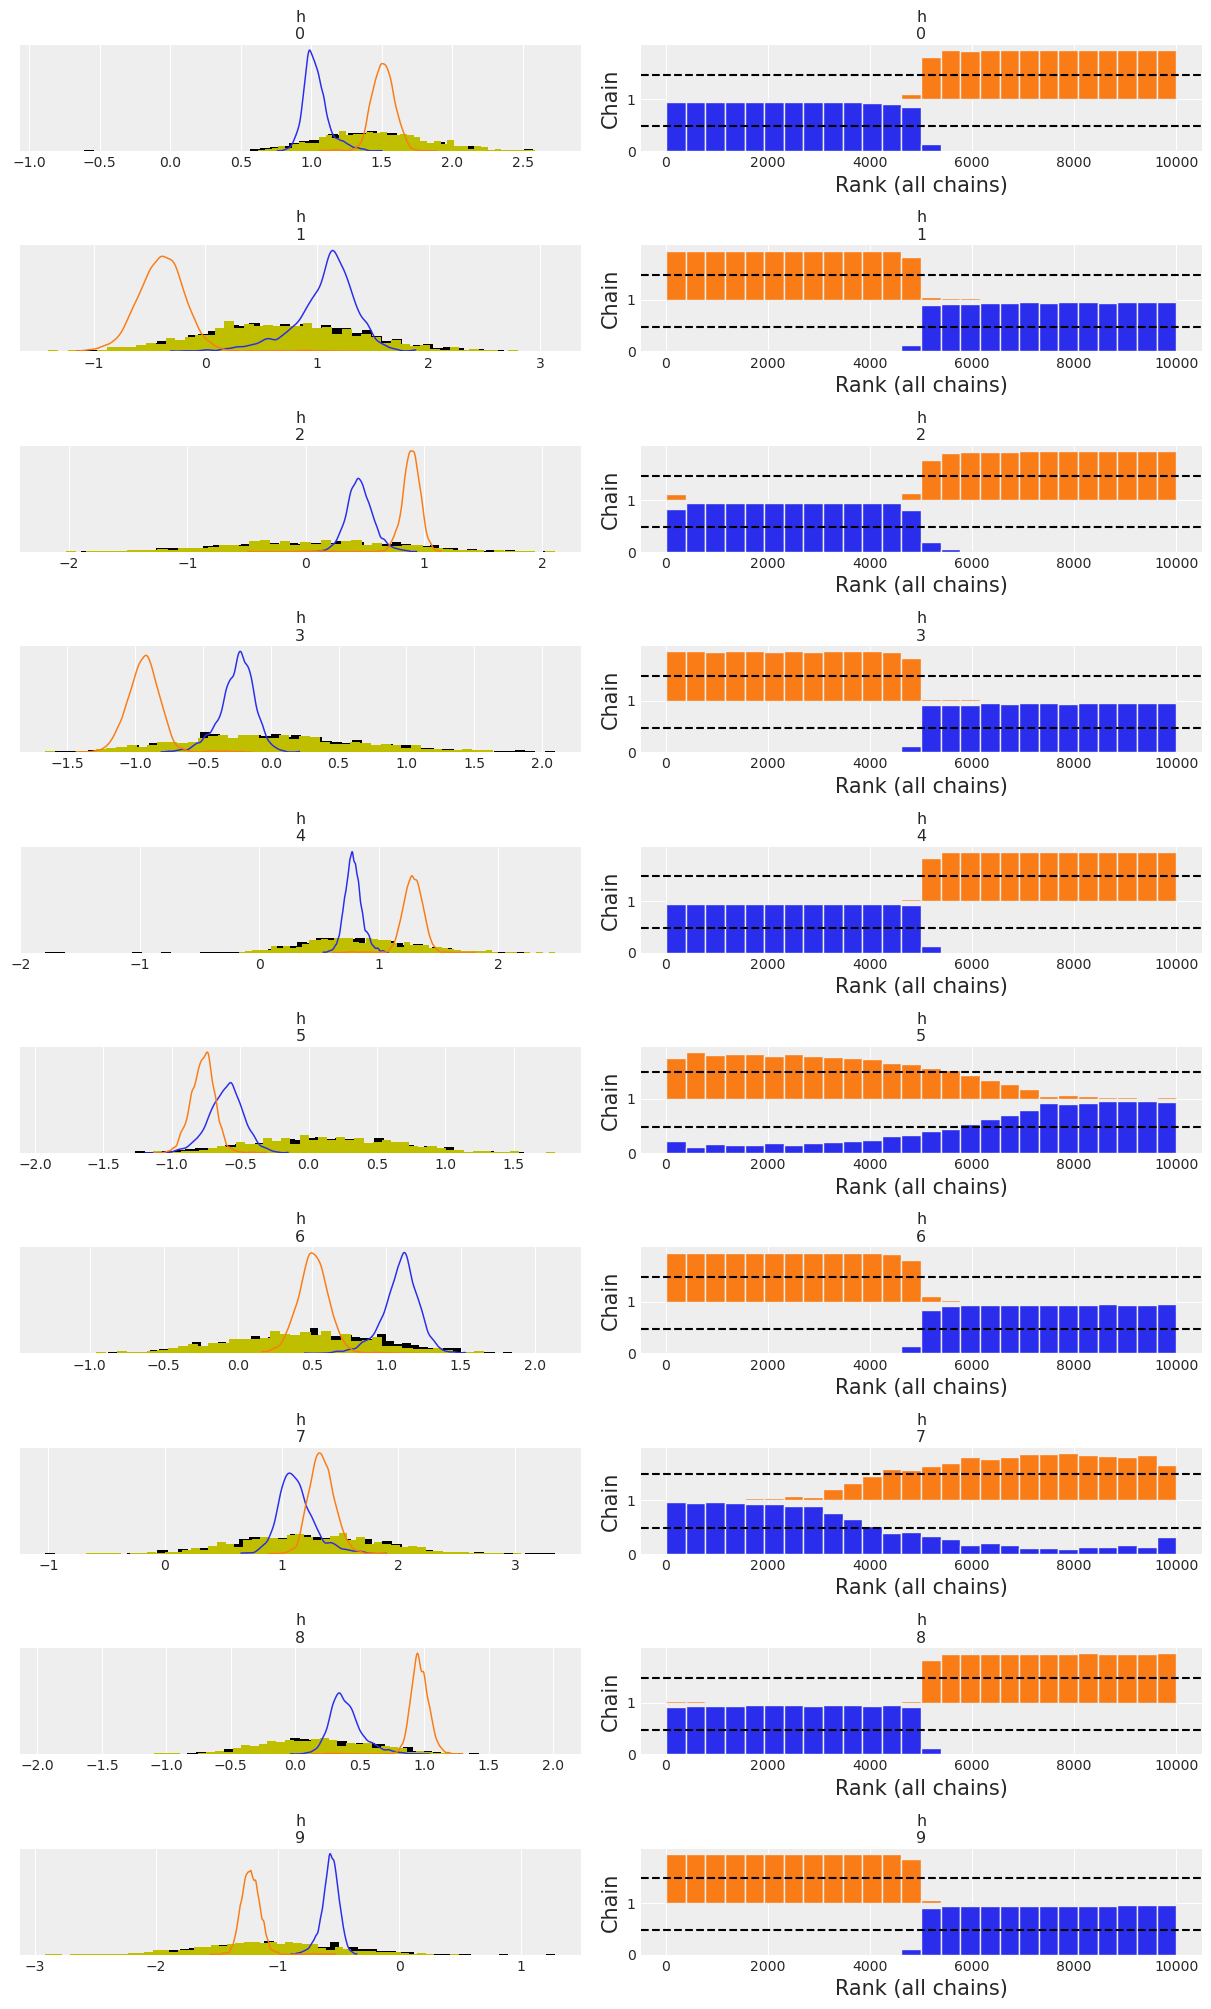

BATCH 5


<Figure size 720x480 with 0 Axes>

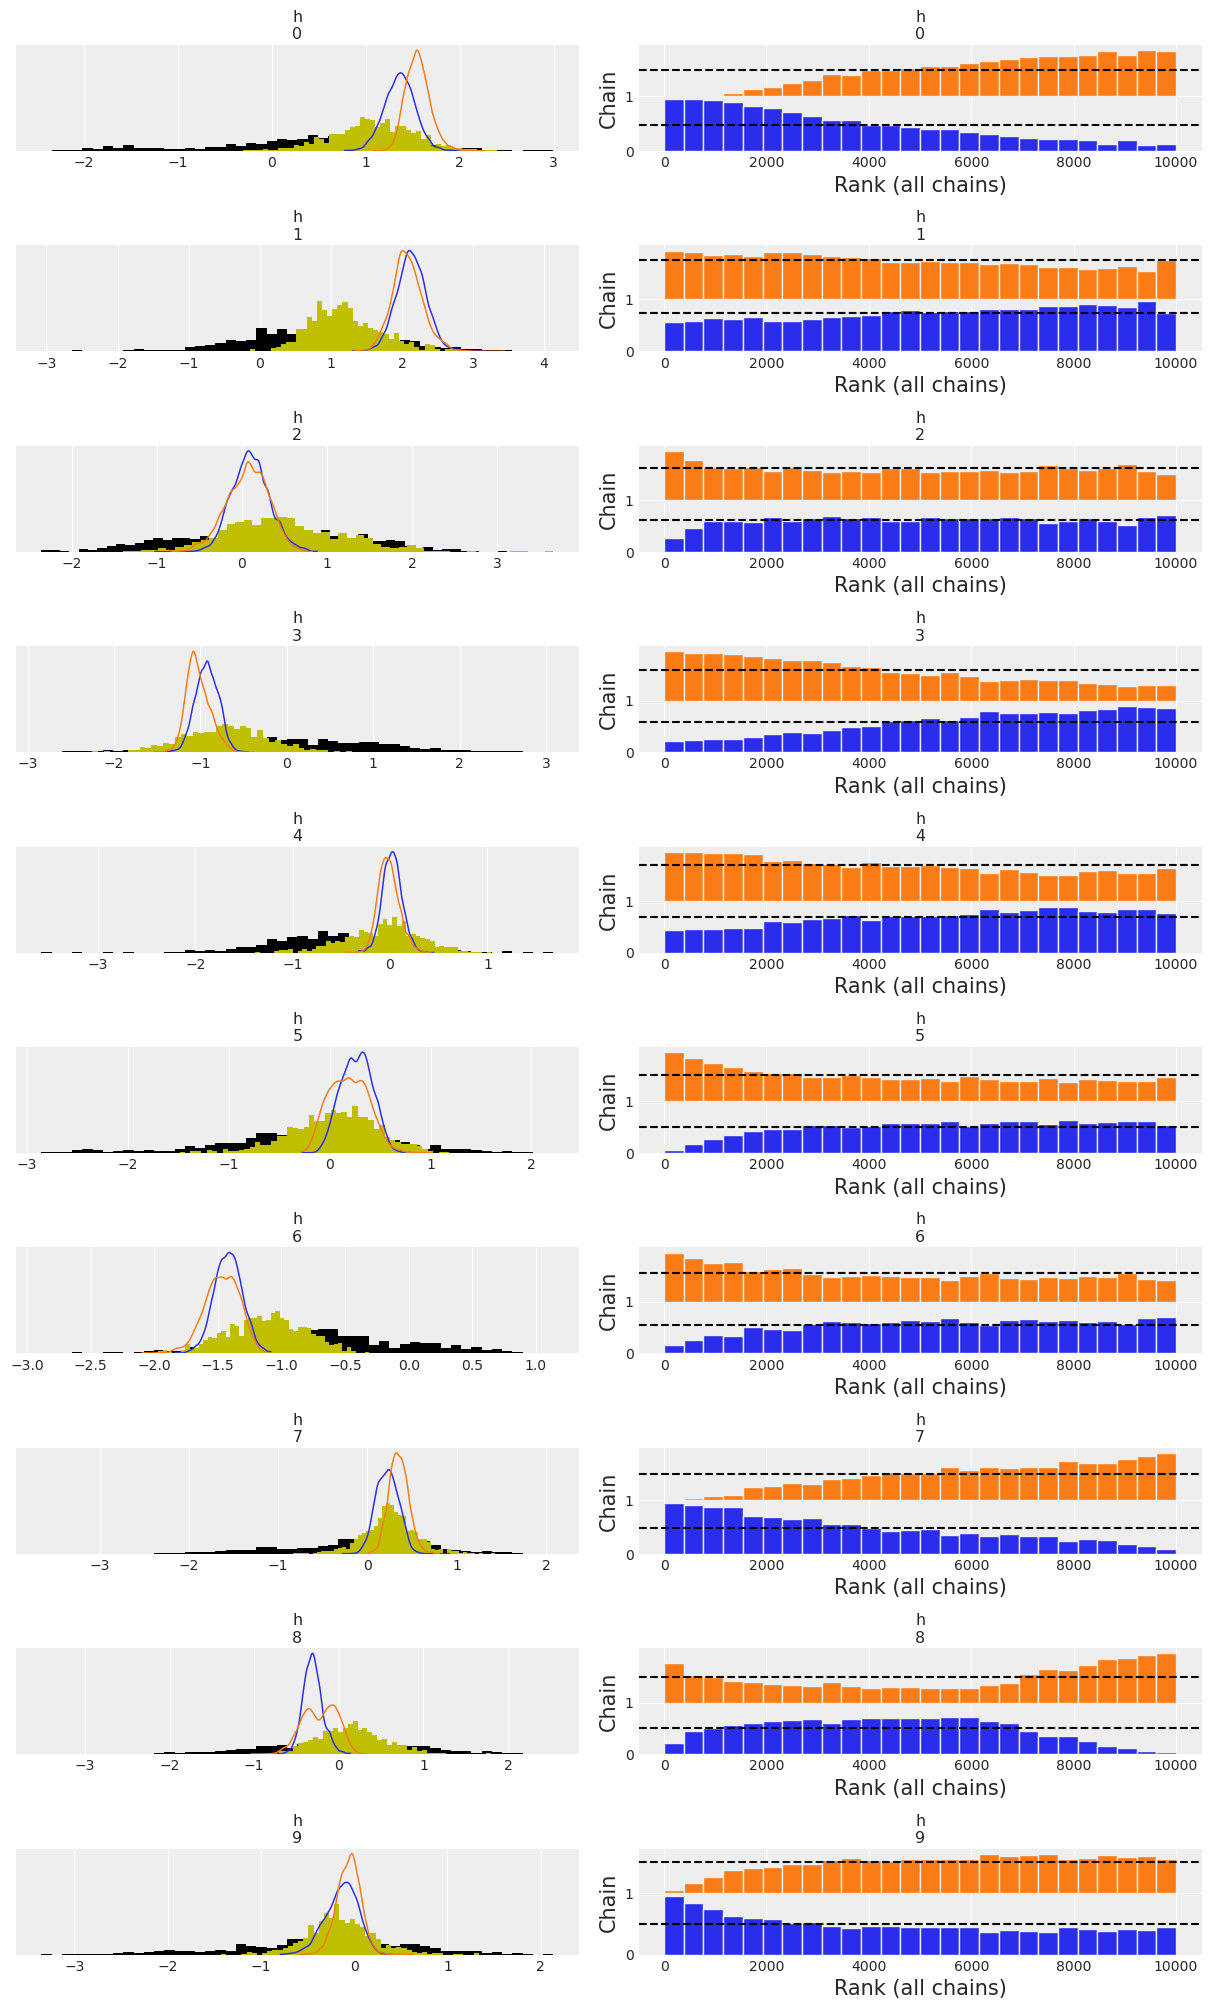

In [21]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(ns_nfmc_az_traces[ib], compact=False, kind="rank_bars")
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()

# NF SMC (no reg)

In [24]:
nf_smc_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        nf_smc_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.,0.), NBfirstlayer=True, k_trunc=0.25)
        nf_smc_az_trace = az.from_pymc3(nf_smc_trace)
        nf_smc_az_traces.append(nf_smc_az_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.002
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.004
Stage:   5 Beta: 0.004
Stage:   6 Beta: 0.004
Stage:   7 Beta: 0.005
Stage:   8 Beta: 0.005
Stage:   9 Beta: 0.006
Stage:  10 Beta: 0.006
Stage:  11 Beta: 0.007
Stage:  12 Beta: 0.008
Stage:  13 Beta: 0.008
Stage:  14 Beta: 0.010
Stage:  15 Beta: 0.010
Stage:  16 Beta: 0.012
Stage:  17 Beta: 0.014
Stage:  18 Beta: 0.015
Stage:  19 Beta: 0.016
Stage:  20 Beta: 0.018
Stage:  21 Beta: 0.020
Stage:  22 Beta: 0.022
Stage:  23 Beta: 0.024
Stage:  24 Beta: 0.026
Stage:  25 Beta: 0.028
Stage:  26 Beta: 0.031
Stage:  27 Beta: 0.033
Stage:  28 Beta: 0.036
Stage:  29 Beta: 0.038
Stage:  30 Beta: 0.041
Stage:  31 Beta: 0.044
Stage:  32 Beta: 0.046
Stage:  33 Beta: 0.050
Stage:  34 Beta: 0.052
Stage:  35 Beta: 0.056
Stage:  36 Beta: 0.058
Stage:  37 Beta: 0.062
Stage:  38 Beta: 0.065
Stage:  39 Beta: 0.068
Stage:  40 Beta: 0.07

BATCH 4


<Figure size 720x480 with 0 Axes>

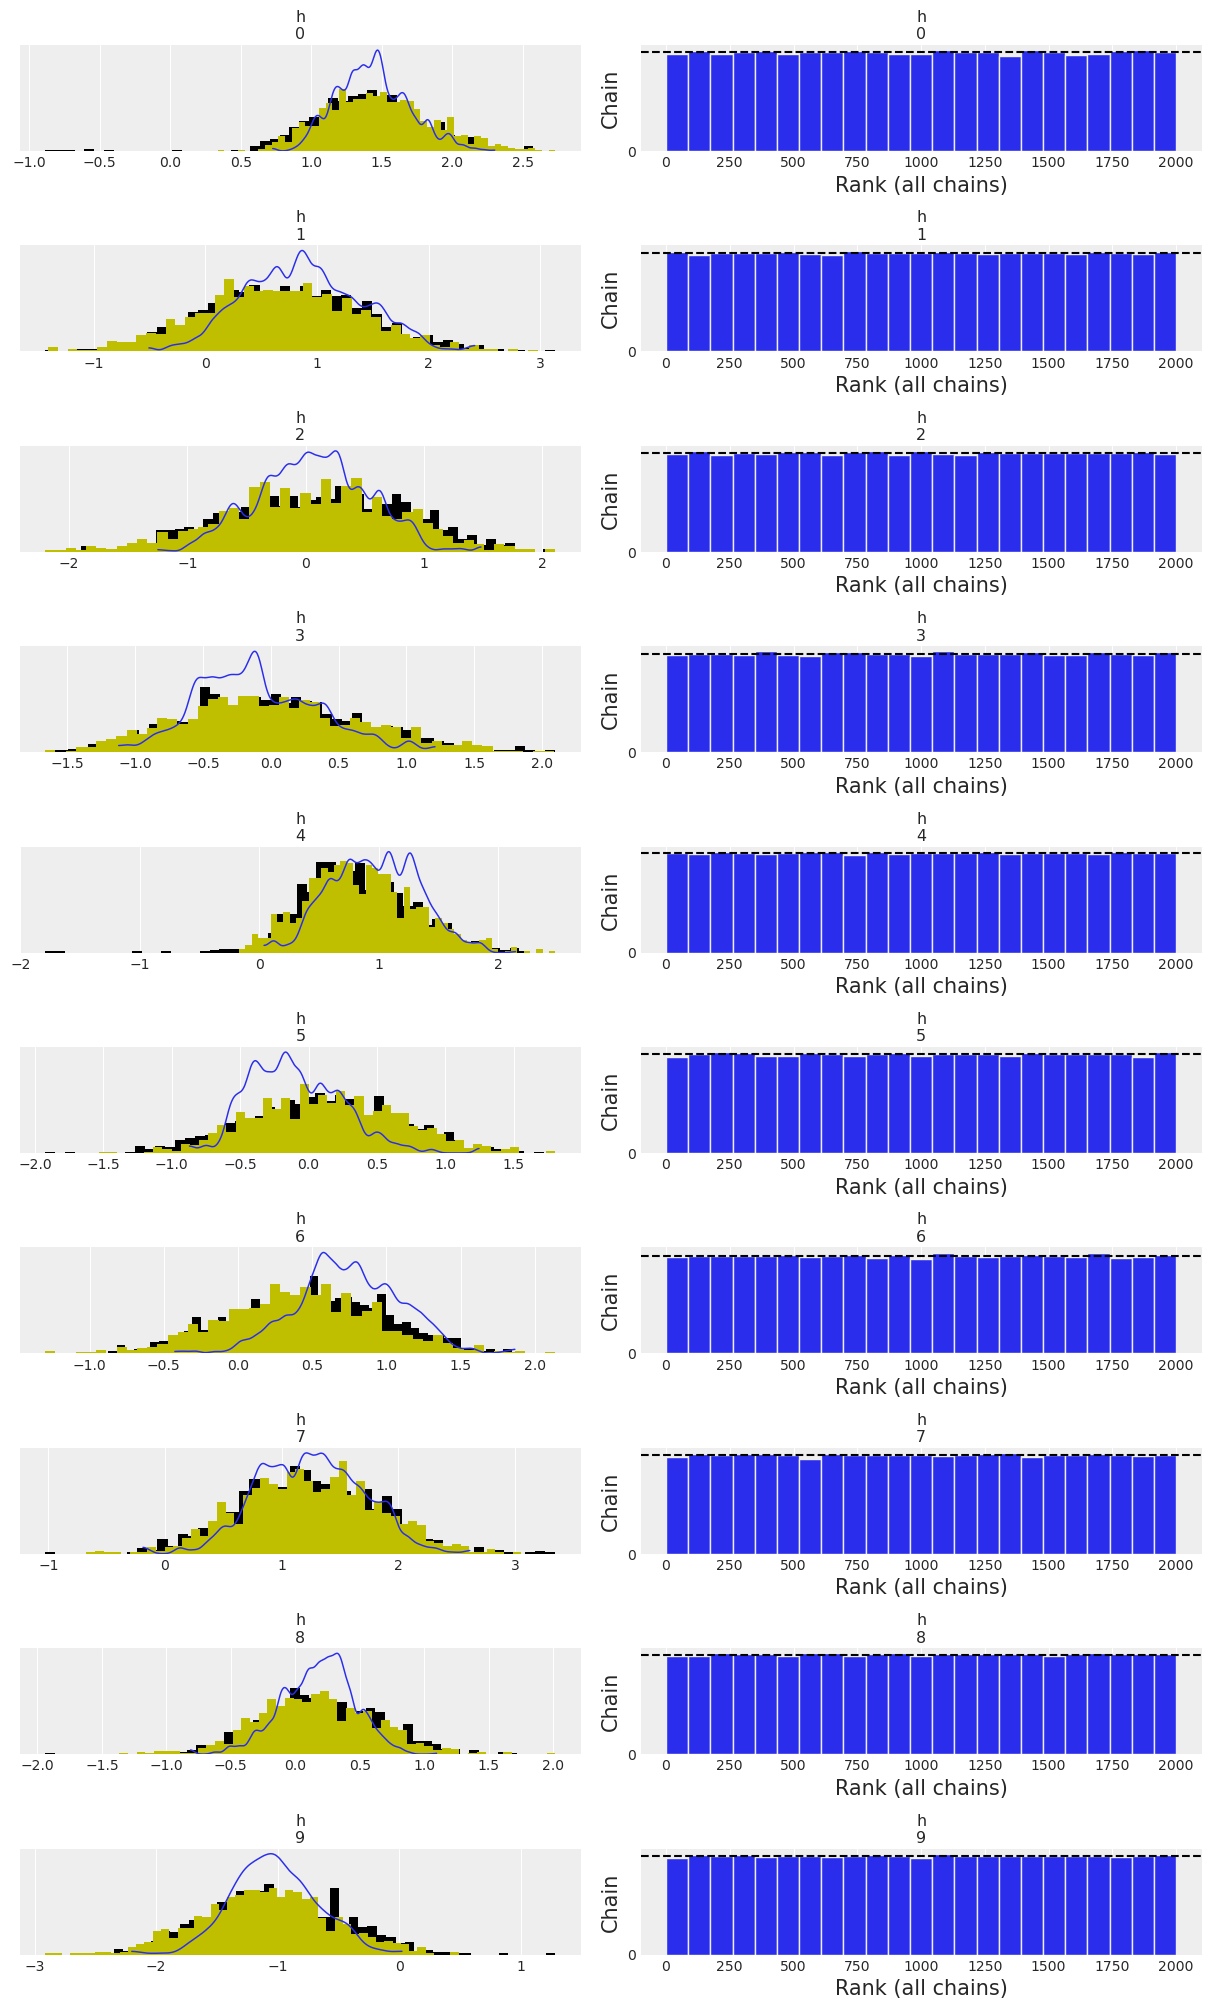

BATCH 5


<Figure size 720x480 with 0 Axes>

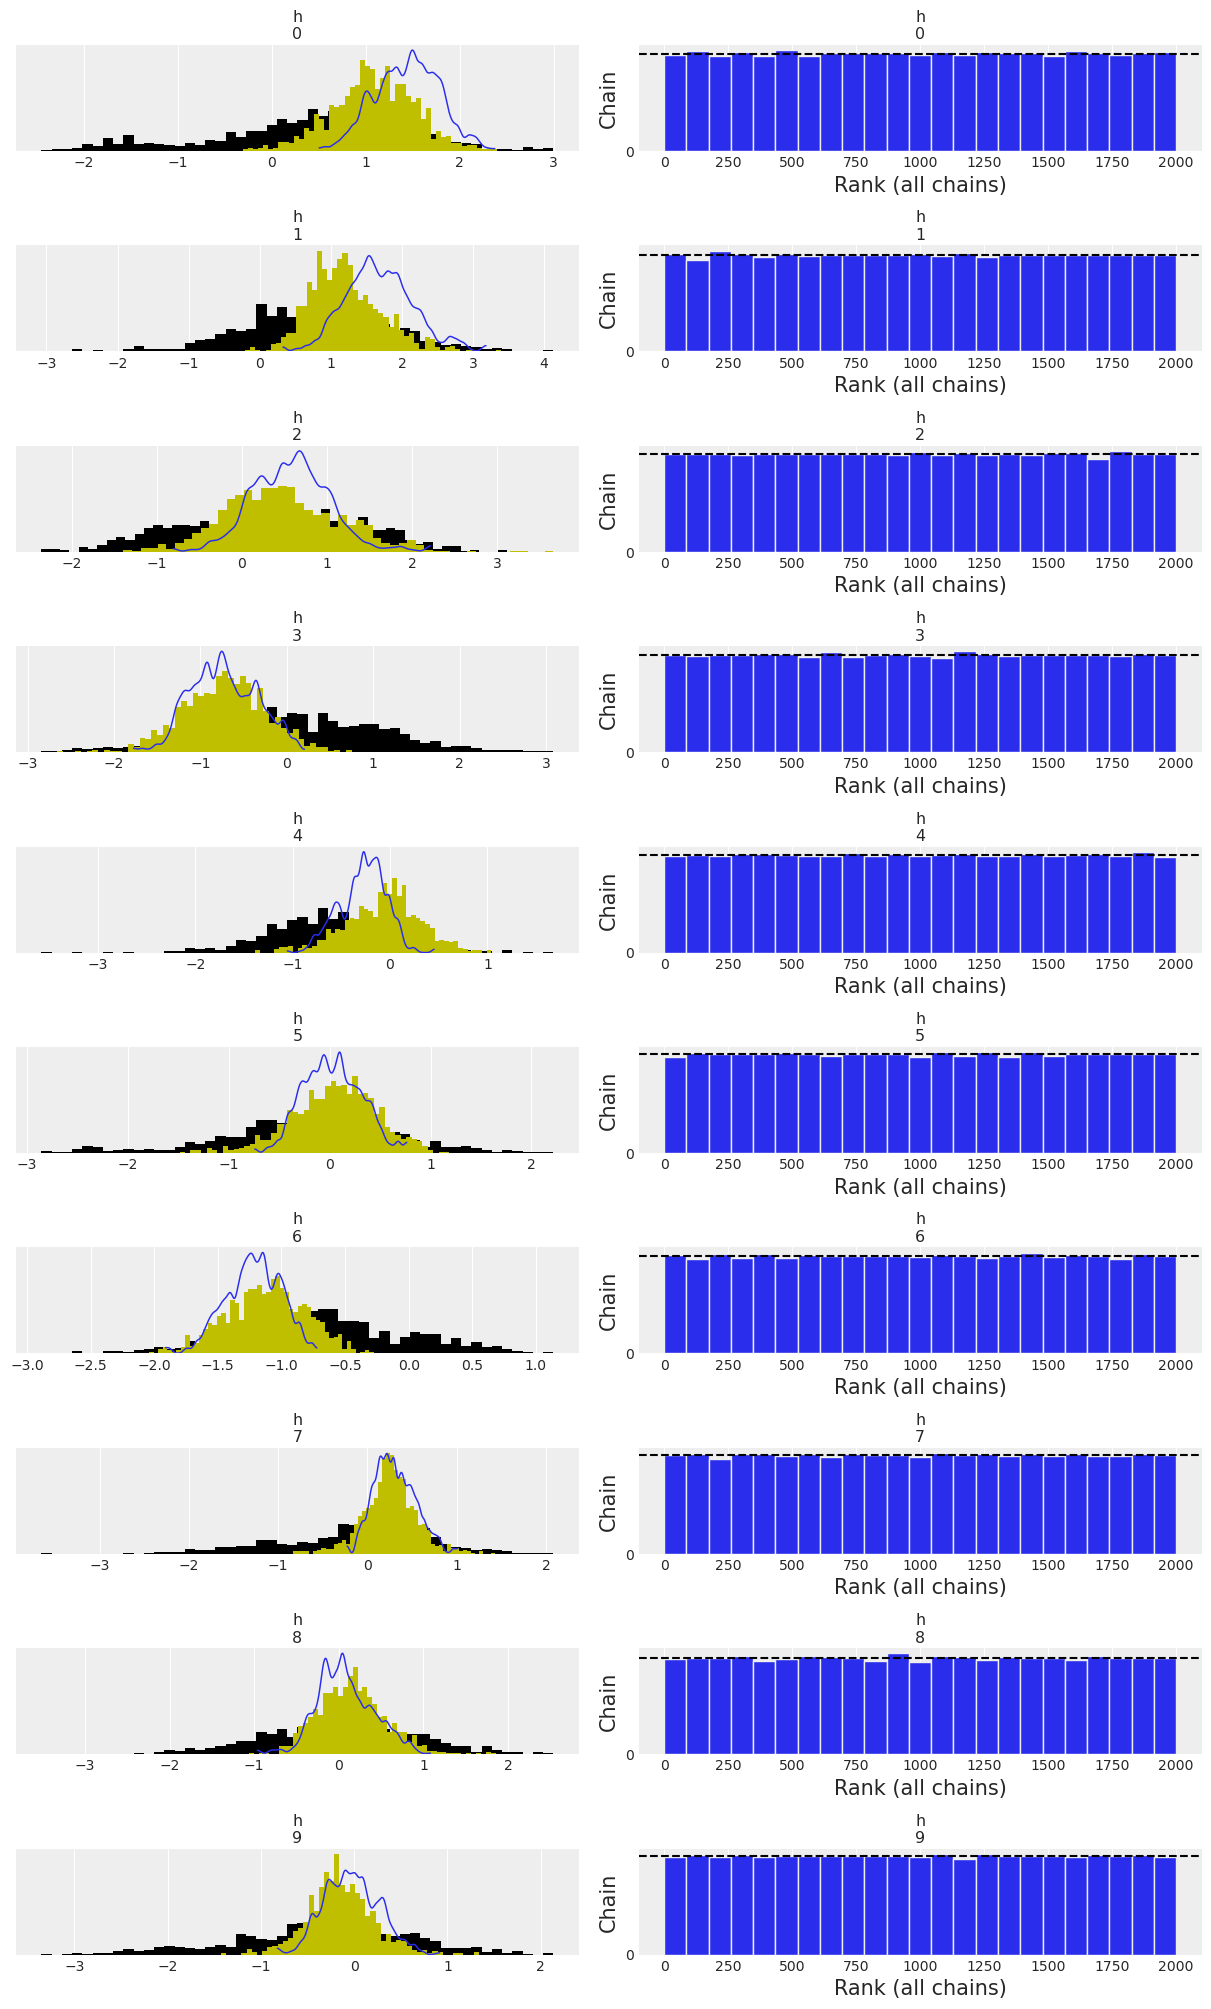

In [25]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(nf_smc_az_traces[ib], compact=False, kind="rank_bars")
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()

# NF SMC (reg)

In [26]:
nf_smc_az_traces = []

for b in batches:
    gmmn10 = pm.Model()
    with gmmn10:
        h = pm.Normal('h', mu=0, sigma=1, shape=hdim)

        llk = pm.Potential("llk", gmmn10_llk(X[b], h))
        nf_smc_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.75,0.75), NBfirstlayer=True, k_trunc=0.25)
        nf_smc_az_trace = az.from_pymc3(nf_smc_trace)
        nf_smc_az_traces.append(nf_smc_az_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/global/homes/a/abayer/source/pymc3/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.002
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.004
Stage:   5 Beta: 0.004
Stage:   6 Beta: 0.005
Stage:   7 Beta: 0.005
Stage:   8 Beta: 0.006
Stage:   9 Beta: 0.007
Stage:  10 Beta: 0.008
Stage:  11 Beta: 0.009
Stage:  12 Beta: 0.011
Stage:  13 Beta: 0.014
Stage:  14 Beta: 0.018
Stage:  15 Beta: 0.020
Stage:  16 Beta: 0.025
Stage:  17 Beta: 0.029
Stage:  18 Beta: 0.033
Stage:  19 Beta: 0.038
Stage:  20 Beta: 0.043
Stage:  21 Beta: 0.048
Stage:  22 Beta: 0.052
Stage:  23 Beta: 0.056
Stage:  24 Beta: 0.061
Stage:  25 Beta: 0.066
Stage:  26 Beta: 0.071
Stage:  27 Beta: 0.076
Stage:  28 Beta: 0.082
Stage:  29 Beta: 0.088
Stage: 

BATCH 4


<Figure size 720x480 with 0 Axes>

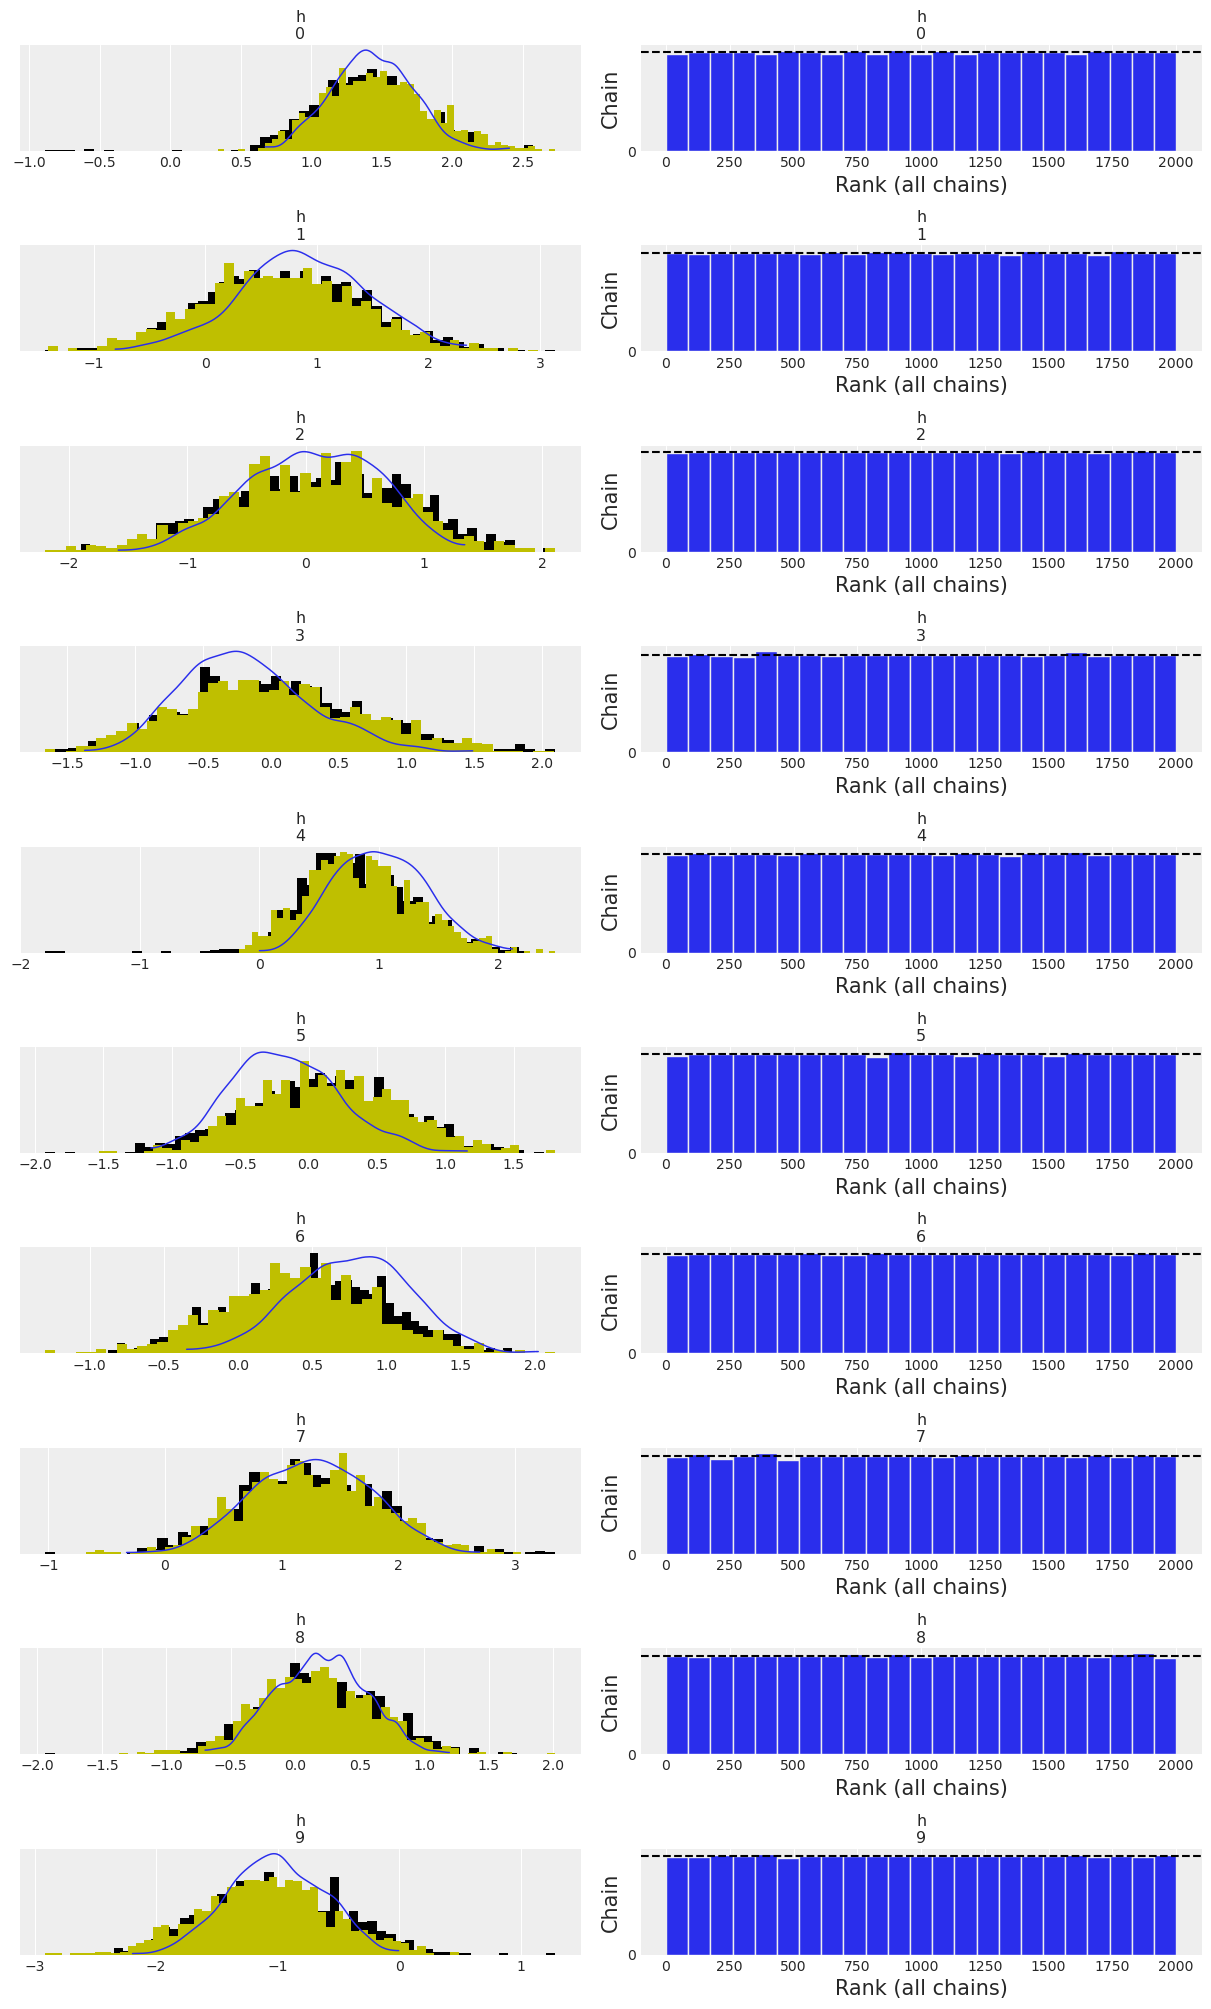

BATCH 5


<Figure size 720x480 with 0 Axes>

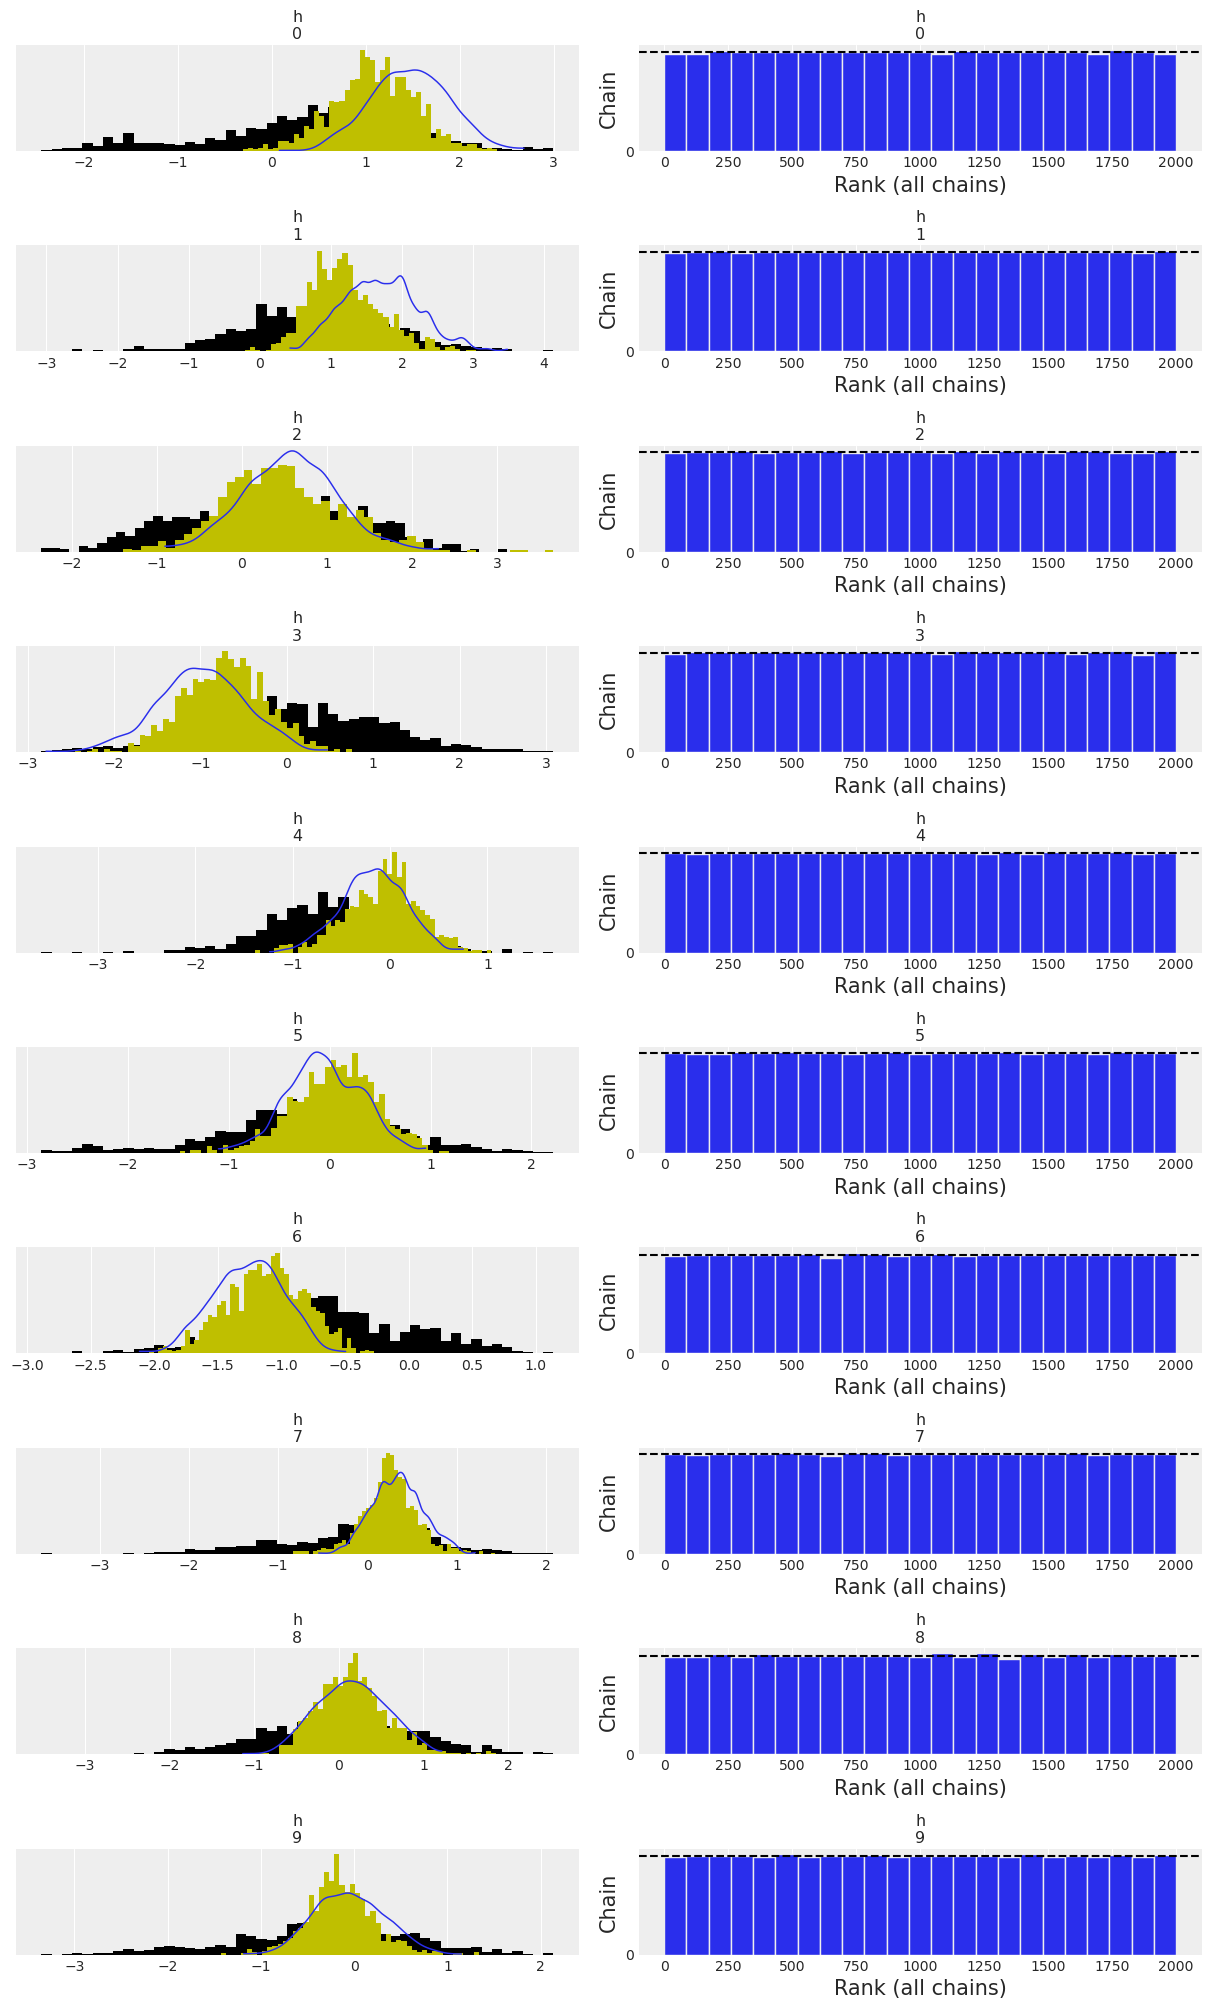

In [37]:
for ib,b in enumerate(batches):
    plt.figure()
    print('BATCH %d'%b)
    ax = az.plot_trace(nf_smc_az_traces[ib], compact=False, kind="rank_bars")
    for ih in range(len(ax)):
        ax[ih, 0].hist(xp_SA[:,b,ih], bins=50, density=1, color='k', label='SA')
        ax[ih, 0].hist(xp_SMC[:,b,ih], bins=50, density=1, color='y', label='ESA')
    plt.show()